##### Neil T. Banerjee <br> HOME Experiment 1 Data Analysis <br> Begin 08.04.2020 

In [82]:
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns

# Set matplotlib parameters for displaying graphs
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images
plt.rcParams['font.size']= 14

# import mpld3
# mpld3.enable_notebook()

pd.set_option('display.max_columns', None)

### BASELINE

In [85]:
# Read in data directly from .acq file and rename dataframe columns
# ACQ file has pre-named colums so you need to make them easier to deal with later in the script
# subject numbers are 201-215
# raw data is barely useful, in units of voltage (RSP), microsiemens (EDA), mV (ECG), and V (TRIG)

data, sampling_rate = nk.read_acqknowledge('part201_baseline.acq')
data = data.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})
print(data.head())

        RSP       EDA       ECG      TRIG
0  7.755737 -0.259534  0.040741  8.486328
1  7.756042 -0.261060  0.042114  8.489075
2  7.755737 -0.262586  0.043030  8.496399
3  7.755432 -0.258008  0.044403  8.493042
4  7.756042 -0.259534  0.045776  8.482056


In [87]:
# Process ECG, EDA, and RSP over the entire experiment
# takes the unidimensional psychophys data and derives relevant features for each subject

ecg_signals, info1 = nk.ecg_process(data["ECG"], sampling_rate=2000)
eda_signals, info2 = nk.eda_process(data["EDA"], sampling_rate=2000)
rsp_signals, info3 = nk.rsp_process(data["RSP"], sampling_rate=2000)

In [81]:
# Summary ECG signals over baseline

display(nk.ecg_analyze(ecg_signals))

,ECG_Rate_Mean,ECG_HRV_RMSSD,ECG_HRV_MeanNN,ECG_HRV_SDNN,ECG_HRV_SDSD,ECG_HRV_CVNN,ECG_HRV_CVSD,ECG_HRV_MedianNN,ECG_HRV_MadNN,ECG_HRV_MCVNN,ECG_HRV_pNN50,ECG_HRV_pNN20,ECG_HRV_TINN,ECG_HRV_HTI,ECG_HRV_ULF,ECG_HRV_VLF,ECG_HRV_LF,ECG_HRV_HF,ECG_HRV_VHF,ECG_HRV_LFHF,ECG_HRV_LFn,ECG_HRV_HFn,ECG_HRV_LnHF,ECG_HRV_SD1,ECG_HRV_SD2,ECG_HRV_SD2SD1,ECG_HRV_CSI,ECG_HRV_CVI,ECG_HRV_CSI_Modified,ECG_HRV_SampEn
0,65.124884,104.582055,1843.384615,137.126389,105.320444,0.074388,0.056734,1806.0,145.2948,0.080451,66.153846,84.615385,540.0,4.0625,0.0,1210.133983,3815.098094,65.829854,0.021817,57.95392,0.749369,0.01293,4.187073,74.4728,179.056123,2.404316,2.404316,5.329107,1722.029811,1.722767


In [78]:
# Summary EDA signals over baseline

EDA_epochs_baseline = nk.epochs_create(eda_signals, events=[0], sampling_rate=2000, epochs_start= 0, epochs_end=60)

baseTonic = (EDA_epochs_baseline['1']['EDA_Tonic'].mean())
print('Tonic:',baseTonic)
basePhasic = (EDA_epochs_baseline['1']['EDA_Phasic'].mean())
print('Phasic',basePhasic)

Tonic: -0.004968598877498141
Phasic -0.00041282427459582666


In [6]:
# Summary RSP Signals

display(nk.rsp_analyze(rsp_signals))

NeuroKit warning: complexity_dfa(): DFA with less than ten data points is unreliable.


,RSP_Rate_Mean,RSP_Amplitude_Mean,RSP_RRV_SDBB,RSP_RRV_RMSSD,RSP_RRV_SDSD,RSP_RRV_VLF,RSP_RRV_LF,RSP_RRV_HF,RSP_RRV_LFHF,RSP_RRV_LFn,RSP_RRV_HFn,RSP_RRV_SD1,RSP_RRV_SD2,RSP_RRV_SD2SD1,RSP_RRV_ApEn,RSP_RRV_SampEn,RSP_RRV_DFA
0,9.749466,3.477905,5532.153103,5613.99243,6046.922909,7555.557029,75.199138,0.127033,591.967378,0.009855,0.000017,4275.820194,6551.854514,1.532304,0.182322,-inf,-0.423717


### TRIGGER FINDER

In [88]:
# Read in data directly from .acq file and rename dataframe columns
# change the participant number in first line

data, sampling_rate = nk.read_acqknowledge('part201_pilot.acq')
data = data.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})
print(data.head())

        RSP       EDA       ECG      TRIG
0  6.958313 -0.534233 -0.032654  8.494263
1  6.957703 -0.535759 -0.032043  8.424683
2  6.957703 -0.538811 -0.031281  8.443604
3  6.957703 -0.534233 -0.031128  8.554993
4  6.955261 -0.535759 -0.031128  8.601990


In [93]:
# Using video timestamps, record min and sec for each trial start and trust feedback, insert into lists
# Estimate the offset between video time and BioPac time and subtract in while loop
# Printed values are the sample numbers where you should start to look for trigger onsets
# Each sample is 0.0005 seconds, we only need .01 seconds resolution, so to the nearest 20 samples

mins_201 = [1,8,13,18,23,29,33,38,42,48,53,56]
secs_201 = [58,46,10,14,25,21,36,33,25,48,1,59]

mins_202 = [1,10,15,20,25,29,34,44,49,53,58,63]
secs_202 = [4,1,27,24,40,59,35,25,2,31,34,31]

mins_203 = [2,8,15,19,25,29,34,44,49,53,58,63]
secs_203 = [28,57,22,57,7,23,12,48,16,35,20,35]

mins_204 = [1,12,16,20,25,29,36,40,44,48,52,56]
secs_204 = [59,42,37,54,41,53,30,36,5,15,7,3]

mins_205 = [2,10,17,22,28,34,40,46,51,56,62,68]
secs_205 = [13,38,17,57,48,14,26,5,29,45,40,25]

mins_206 = [4,12,17,22,27,32,36,41,46,51,55,60]
secs_206 = [11,32,24,5,0,5,59,34,44,15,53,23]

mins_207 = [2,8,13,17,22,27,32,36,41,45,49,54]
secs_207 = [52,45,17,44,23,47,15,42,10,39,43,25]

mins_208 = [2,10,17,22,27,32,36,41,45,50,55,60]
secs_208 = [8,3,4,10,13,1,32,10,49,30,18,3]

mins_209 = [2,7,12,16,20,25,29,36,39,43,47,52]
secs_209 = [4,42,20,28,56,3,4,6,59,57,49,19]

mins_210 = [2,9,15,19,23,28,32,36,40,43,47,52]
secs_210 = [1,52,9,38,48,2,8,10,5,54,57,14]

mins_211 = [2,8,12,16,19,23,26,30,34,37,41,45]
secs_211 = [55,2,18,0,47,24,52,33,13,54,56,44]

mins_212 = [1,9,13,18,22,27,32,36,41,45,49,54]
secs_212 = [56,16,55,20,48,25,13,34,18,22,15,2]

index = []

i=0
while i<12:
    index.append((mins_201[i]*60+secs_201[i])*2000-41402)
    i+=1
    
print(index)

[194598, 1010598, 1538598, 2146598, 2768598, 3480598, 3990598, 4584598, 5048598, 5814598, 6320598, 6796598]


<IPython.core.display.Javascript object>


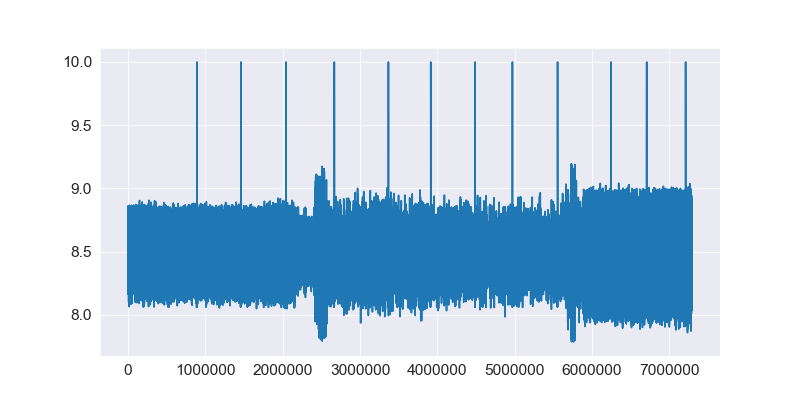

In [94]:
data['TRIG'].plot()

In [95]:
###### Using the plot tool to identify trigger locations, input these into trigValues
# compare index and start values here, and retain the ones that match loosely. These will be
# the real start times where the trigger dips.

# # print(str(index))
# data['TRIG'].plot()

# start = [] 
# for idx in range(0, len(data['TRIG'])) : 
#     if idx==0:
#         pass
#     elif data['TRIG'][idx] < 8.15 and data['TRIG'][idx]-data['TRIG'][idx-1]<-0.3: 
#         start.append(idx) 
# print(start)
# # print(index)

# feed = [] 
# for idx in range(0, len(data['TRIG'])) : 
#     if data['TRIG'][idx] > 9.5: 
#         feed.append(idx) 

# feed_half = []
# i=0
# while i<len(feed):
#     if i%2==0 or i==0:
#         feed_half.append(feed[i])
#     i+=1


# # print result 
# print("Feedback Triggers : " + str(feed_half))

start_times1 = [194698, 1005561, 1540609, 2147360, 2769599, 3481276, 3992184, 4585703, 5050115, 5815969, 6322160, 6797957]
start_times2 = [194454, 1269507, 1922593, 2516873, 3148865, 3666784, 4218548, 5397350, 5952422, 6491108, 7097252, 7691496]
start_times3 = [314593, 1092369, 1862621, 2414184, 3032840, 3545293, 4123413, 4676535, 5212411, 5729779, 6179051, 6690540]
start_times4 = [265914, 1552433, 2022083, 2536588, 3110579, 3613764, 4408422, 4901834, 5318674, 5819387, 6282494, 6753798]
start_times5 = [334600, 1344849, 2142669, 2821669, 3524315, 4173711, 4921500, 5597520, 6247026, 6878043, 7588660, 8279468]

feedback_times1 = [889951, 1458686, 2041655, 2666775, 3366462, 3914176, 4488729, 4970775, 5554773, 6246421, 6707678, 7211068]
feedback_times2 = [1125866, 1849636, 2428222, 3067840, 3605520, 4148242, 4810943, 5863661, 6424679, 7021668, 7591709, 8229150]
feedback_times3 = [1013628, 1792001, 2346446, 2960952, 3479071, 4046890, 4609607, 5151855, 5662696, 6115721, 6585551, 7119120]
feedback_times4 = [1412772, 1939638, 2449338, 2992715, 3506868, 4332269, 4824195, 5246587, 5735214, 6209677, 6647662, 7106437]
feedback_times5 = [1261678, 2066838, 2754357, 3446248, 4096990, 4836504, 5521250, 6174368, 6803506, 7503325, 8170261, 8846106]


### PILOTING TRIALS

In [96]:
# Read in data directly from .acq file and rename dataframe columns
# Define the taskload list in order [Low, Low, Low, Med, Med, Med, High, High, High]
# Define reliability list in order [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# also need to change participant numbers here
# rel = reliability, lock is lock-in time for voltage decision

lowTask1 = ['1','4','8','12']
medTask1 = ['3','6','7','10']
highTask1 = ['2','5','9','11']
rel1 = [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
lock1 = [4, 4.73333333333333, 7.70000000000000, 4.36666666666667, 5.80000000000000, 5, 3.83333333333334, 4.40000000000000, 5.60000000000000, 3.60000000000000, 3.56666666666666, 3.86666666666667]

lowTask2 = ['1','5','6','9']
medTask2 = ['3','4','8','12']
highTask2 = ['2','7','10','11']
rel2 = [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
lock2 = [4.60000000000000, 4.80000000000000, 3.53333333333333, 4.93333333333333, 3.53333333333333, 6.13333333333333, 4.20000000000000, 3.43333333333333, 6.63333333333333, 3.10000000000000, 3.36666666666667, 3.66666666666666]

lowTask3 = ['3','5','7','10']
medTask3 = ['1','2','4','12']
highTask3 = ['6','8','9','11']
rel3 = [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
lock3 = [3.76666666666667, 4.20000000000000, 5.06666666666666, 4.86666666666667, 4.16666666666666, 4.46666666666667, 3.83333333333334, 4.76666666666667, 3.26666666666667, 3.93333333333333, 3.70000000000000, 3.33333333333334]

lowTask4 = ['7','9','11','12']
medTask4 = ['1','2','8','10']
highTask4 = ['3','4','5','6']
rel4 = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
lock4 = [3.76666666666667, 4.20000000000000, 5.06666666666666, 4.86666666666667, 4.16666666666666, 4.46666666666667, 3.83333333333334, 4.76666666666667, 3.26666666666667, 3.93333333333333, 3.70000000000000, 3.33333333333334]

lowTask5 = ['2','6','7','10']
medTask5 = ['3','4','5','8']
highTask5 = ['1','9','11','12']
rel5 = [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
lock5 = [5.16666666666666, 4.10000000000000, 4.33333333333334, 5.66666666666666, 4.03333333333333, 3.73333333333333, 5.03333333333333, 8.33333333333334, 5.13333333333333, 5.76666666666667, 3.73333333333333, 6.06666666666666]

data1, sampling_rate = nk.read_acqknowledge('part201_pilot.acq')
data1 = data1.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})

print(data1.head())

        RSP       EDA       ECG      TRIG
0  6.958313 -0.534233 -0.032654  8.494263
1  6.957703 -0.535759 -0.032043  8.424683
2  6.957703 -0.538811 -0.031281  8.443604
3  6.957703 -0.534233 -0.031128  8.554993
4  6.955261 -0.535759 -0.031128  8.601990


In [97]:
# Process ECG, EDA, and RSP over the entire experiment

ecg_signals, info1 = nk.ecg_process(data1["ECG"], sampling_rate=2000)
eda_signals, info2 = nk.eda_process(data1["EDA"], sampling_rate=2000)
rsp_signals, info3 = nk.rsp_process(data1["RSP"], sampling_rate=2000)

#### Electrocardiogram (Piloting)

In [99]:
ECG_epochs_piloting = nk.epochs_create(ecg_signals, events=start_times1, sampling_rate=2000, epochs_start= 0, epochs_end=50)

display(nk.ecg_analyze(ECG_epochs_piloting))

print((ECG_epochs_piloting[lowTask5[0]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[lowTask5[1]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[lowTask5[2]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[lowTask5[3]]['ECG_Rate'].mean())/4)

print((ECG_epochs_piloting[medTask5[0]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[medTask5[1]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[medTask5[2]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[medTask5[3]]['ECG_Rate'].mean())/4)

print((ECG_epochs_piloting[highTask5[0]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[highTask5[1]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[highTask5[2]]['ECG_Rate'].mean()+
         ECG_epochs_piloting[highTask5[3]]['ECG_Rate'].mean())/4)

print('\n')

# hrv = nk.ecg_analyze(ECG_epochs_piloting)['ECG_HRV_RMSSD']
# print(hrv[lowTask5[0:4]].mean())
# print(hrv[medTask5[0:4]].mean())
# print(hrv[highTask5[0:4]].mean())


,ECG_Rate_Mean,ECG_HRV_RMSSD,ECG_HRV_MeanNN,ECG_HRV_SDNN,ECG_HRV_SDSD,ECG_HRV_CVNN,ECG_HRV_CVSD,ECG_HRV_MedianNN,ECG_HRV_MadNN,ECG_HRV_MCVNN,ECG_HRV_pNN50,ECG_HRV_pNN20,ECG_HRV_TINN,ECG_HRV_HTI,ECG_HRV_ULF,ECG_HRV_VLF,ECG_HRV_LF,ECG_HRV_HF,ECG_HRV_VHF,ECG_HRV_LFHF,ECG_HRV_LFn,ECG_HRV_HFn,ECG_HRV_LnHF,ECG_HRV_SD1,ECG_HRV_SD2,ECG_HRV_SD2SD1,ECG_HRV_CSI,ECG_HRV_CVI,ECG_HRV_CSI_Modified,ECG_HRV_SampEn
1,77.857078,105.738071,1543.062500,139.526054,106.576318,0.090422,0.068525,1535.0,106.0059,0.069059,53.125000,71.875000,639.0,3.764706,0.0,5333.462388,9228.796666,1231.267596,5.234209,7.495362,0.584147,0.077934,7.115799,75.360837,182.361684,2.419847,2.419847,5.342199,1765.149392,1.981001
2,79.659582,87.630518,1506.515152,85.360456,88.284252,0.056661,0.058168,1497.5,87.4734,0.058413,51.515152,74.242424,377.0,4.400000,0.0,142.786616,1582.578951,1438.408459,4.696892,1.100229,0.499477,0.453976,7.271293,62.426393,103.323571,1.655126,1.655126,5.013688,684.054279,3.218876
3,77.563694,99.790495,1550.453125,96.453942,100.566012,0.062210,0.064362,1547.0,102.2994,0.066128,59.375000,84.375000,419.0,3.764706,0.0,364.959340,2753.317341,1289.623243,3.811351,2.134978,0.624093,0.292318,7.162105,71.110909,116.404314,1.636940,1.636940,5.122025,762.187657,2.302585
4,79.205197,79.393403,1519.646154,92.878185,79.870033,0.061118,0.052245,1520.0,88.9560,0.058524,55.384615,75.384615,508.0,4.333333,0.0,1121.823308,1850.065495,1135.336940,2.084053,1.629530,0.450213,0.276284,7.034685,56.476642,118.587956,2.099770,2.099770,5.030029,996.029705,2.047693
5,82.033632,75.762098,1466.176471,108.834523,76.239022,0.074230,0.051673,1457.5,83.7669,0.057473,45.588235,76.470588,501.0,3.400000,0.0,909.641142,2732.708582,923.095756,3.511751,2.960374,0.598103,0.202036,6.827733,53.909130,144.165574,2.674233,2.674233,5.094644,1542.129345,2.397895
6,77.492466,98.524027,1557.682540,119.833867,99.057223,0.076931,0.063250,1556.0,103.7820,0.066698,63.492063,80.952381,567.0,3.315789,0.0,267.526578,3165.795589,1071.106680,2.913167,2.955631,0.702364,0.237636,6.976448,70.044034,154.318322,2.203162,2.203162,5.237909,1359.952774,2.079442
7,74.169908,94.697765,1620.229508,98.338767,95.494550,0.060694,0.058447,1618.0,99.3342,0.061393,68.852459,93.442623,418.0,4.066667,0.0,1013.535269,2666.973360,909.568144,2.160866,2.932131,0.580757,0.198066,6.812970,67.524844,121.578870,1.800506,1.800506,5.118442,875.613827,2.833213
8,72.056391,98.775608,1667.372881,94.683847,99.633867,0.056786,0.059240,1655.0,84.5082,0.051062,59.322034,83.050847,429.0,3.470588,0.0,258.470944,3521.735530,1120.518220,1.126599,3.142952,0.718450,0.228591,7.021547,70.451783,113.871016,1.616297,1.616297,5.108425,736.197592,1.481605
9,70.668294,135.695544,1697.775862,144.410240,136.858236,0.085058,0.079925,1684.0,148.2600,0.088040,74.137931,89.655172,795.0,3.411765,0.0,435.158881,6365.906888,1257.588512,1.435930,5.061995,0.789806,0.156027,7.136951,96.773387,179.843116,1.858394,1.858394,5.444770,1336.877727,1.757858
10,72.020382,157.050837,1671.016949,154.015280,158.413688,0.092169,0.093985,1686.0,109.7124,0.065073,61.016949,83.050847,749.0,3.933333,0.0,4371.531620,15424.125739,6259.592693,88.162516,2.464078,0.589981,0.239433,8.741870,112.015393,186.799264,1.667621,1.667621,5.524773,1246.041780,2.047693


75.83558420899374
77.71472863579196
73.60681600641178




In [65]:
# johnny can ignore this cell for now - just for demonstration

ECG_epochs_piloting = nk.epochs_create(ecg_signals, events=start_times1, sampling_rate=2000, epochs_start= 0, epochs_end=50)
print(nk.ecg_analyze(ECG_epochs_piloting)['ECG_HRV_RMSSD'])

# print((ECG_epochs_piloting['1']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['2']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['3']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['4']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['5']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['6']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['7']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['8']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['9']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['10']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['11']['ECG_Rate'].mean()))
# print((ECG_epochs_piloting['12']['ECG_Rate'].mean()))


# print('\n')


1     102.214628
2     131.503169
3     106.908120
4      45.226590
5      69.049479
6      66.350288
7     121.778263
8      89.814624
9     272.994015
10    110.310524
11    115.469404
12     83.978062
Name: ECG_HRV_RMSSD, dtype: float64


#### Electrodermal Analysis (Piloting)

In [157]:
EDA_epochs_piloting = nk.epochs_create(eda_signals, events=start_times1, sampling_rate=2000, epochs_start= 0, epochs_end=50)

lowTonic = (EDA_epochs_piloting[lowTask5[0]]['EDA_Tonic'].mean()+EDA_epochs_piloting[lowTask5[1]]['EDA_Tonic'].mean()+EDA_epochs_piloting[lowTask5[2]]['EDA_Tonic'].mean()+EDA_epochs_piloting[lowTask5[3]]['EDA_Tonic'].mean())/4
medTonic = (EDA_epochs_piloting[medTask5[0]]['EDA_Tonic'].mean()+EDA_epochs_piloting[medTask5[1]]['EDA_Tonic'].mean()+EDA_epochs_piloting[medTask5[2]]['EDA_Tonic'].mean()+EDA_epochs_piloting[medTask5[3]]['EDA_Tonic'].mean())/4
highTonic = (EDA_epochs_piloting[highTask5[0]]['EDA_Tonic'].mean()+EDA_epochs_piloting[highTask5[1]]['EDA_Tonic'].mean()+EDA_epochs_piloting[highTask5[2]]['EDA_Tonic'].mean()+EDA_epochs_piloting[highTask5[3]]['EDA_Tonic'].mean())/4

lowPhasic = (EDA_epochs_piloting[lowTask5[0]]['EDA_Phasic'].mean()+EDA_epochs_piloting[lowTask5[1]]['EDA_Phasic'].mean()+EDA_epochs_piloting[lowTask5[2]]['EDA_Phasic'].mean()+EDA_epochs_piloting[lowTask5[3]]['EDA_Phasic'].mean())/4
medPhasic = (EDA_epochs_piloting[medTask5[0]]['EDA_Phasic'].mean()+EDA_epochs_piloting[medTask5[1]]['EDA_Phasic'].mean()+EDA_epochs_piloting[medTask5[2]]['EDA_Phasic'].mean()+EDA_epochs_piloting[medTask5[3]]['EDA_Phasic'].mean())/4
highPhasic = (EDA_epochs_piloting[highTask5[0]]['EDA_Phasic'].mean()+EDA_epochs_piloting[highTask5[1]]['EDA_Phasic'].mean()+EDA_epochs_piloting[highTask5[2]]['EDA_Phasic'].mean()+EDA_epochs_piloting[highTask5[3]]['EDA_Phasic'].mean())/4

print('\nLow Taskload Tonic EDA', lowTonic)
print('Medium Taskload Tonic EDA', medTonic)
print('High Taskload Tonic EDA', highTonic)

print('\nLow Taskload Phasic EDA', lowPhasic)
print('Medium Taskload Phasic EDA', medPhasic)
print('High Taskload Phasic EDA', highPhasic, '\n')


Low Taskload Tonic EDA 1.1809057850725977
Medium Taskload Tonic EDA -0.2648178751956727
High Taskload Tonic EDA -3.4743051921368022

Low Taskload Phasic EDA 0.00964643193993672
Medium Taskload Phasic EDA -0.023516952434592984
High Taskload Phasic EDA -0.0829535939938546 



#### Respiration (Piloting)

In [162]:
RSP_epochs_piloting = nk.epochs_create(rsp_signals, events=start_times1, sampling_rate=2000, epochs_start= 0, epochs_end=50)

lowAmp = (RSP_epochs_piloting[lowTask5[0]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[lowTask5[1]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[lowTask5[2]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[lowTask5[3]]['RSP_Amplitude'].mean())/4
medAmp = (RSP_epochs_piloting[medTask5[0]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[medTask5[1]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[medTask5[2]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[medTask5[3]]['RSP_Amplitude'].mean())/4
highAmp = (RSP_epochs_piloting[highTask5[0]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[highTask5[1]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[highTask5[2]]['RSP_Amplitude'].mean()+RSP_epochs_piloting[highTask5[3]]['RSP_Amplitude'].mean())/4

print('\nLow Taskload Respiration Amplitude: ', lowAmp)
print('Medium Taskload Respiration Amplitude: ', medAmp)
print('High Taskload Respiration Amplitude: ', highAmp)

lowRate = (RSP_epochs_piloting[lowTask5[0]]['RSP_Rate'].mean()+RSP_epochs_piloting[lowTask5[1]]['RSP_Rate'].mean()+RSP_epochs_piloting[lowTask5[2]]['RSP_Rate'].mean()+RSP_epochs_piloting[lowTask5[3]]['RSP_Rate'].mean())/4
medRate = (RSP_epochs_piloting[medTask5[0]]['RSP_Rate'].mean()+RSP_epochs_piloting[medTask5[1]]['RSP_Rate'].mean()+RSP_epochs_piloting[medTask5[2]]['RSP_Rate'].mean()+RSP_epochs_piloting[medTask5[3]]['RSP_Rate'].mean())/4
highRate = (RSP_epochs_piloting[highTask5[0]]['RSP_Rate'].mean()+RSP_epochs_piloting[highTask5[1]]['RSP_Rate'].mean()+RSP_epochs_piloting[highTask5[2]]['RSP_Rate'].mean()+RSP_epochs_piloting[highTask5[3]]['RSP_Rate'].mean())/4

print('\nLow Taskload Respiration Rate: ', lowRate)
print('Medium Taskload Respiration Rate: ', medRate)
print('High Taskload Respiration Rate: ', highRate, '\n')


Low Taskload Respiration Amplitude:  2.9371977719759403
Medium Taskload Respiration Amplitude:  3.7274819950865044
High Taskload Respiration Amplitude:  4.26633481432475

Low Taskload Respiration Rate:  20.620910737073718
Medium Taskload Respiration Rate:  23.58067984557877
High Taskload Respiration Rate:  20.9470536222805 



### DECISION TRIALS

In [163]:
# Make an array of trust decision times by adding lockin times to start time + 50 seconds
# Everything from this point on is pretty experimental - proceed with caution

decision_times = [0,0,0,0,0,0,0,0,0,0,0,0]
i=0
for time in start_times:
    decision_times[i] = start_times1[i] + 50*2000 + lock1[i]*2000
    i+=1

print(decision_times)

[302698, 1115027.6666666667, 1656009.0, 2256093.3333333335, 2881199.0, 3591276, 4099850.6666666665, 4694503.0, 5161315.0, 5923169.0, 6429293.333333333, 6905690.333333333]


#### Electrocardiogram (Decision)

In [164]:
ECG_epochs_decision = nk.epochs_create(ecg_signals, events=decision_times, sampling_rate=2000, epochs_start= -10, epochs_end=10)
display(nk.ecg_analyze(ECG_epochs_decision))

# Can look at the reliability of the previouso trial or the trust ratings based on how the analog gauge was behaving

,ECG_Rate_Mean,ECG_HRV_RMSSD,ECG_HRV_MeanNN,ECG_HRV_SDNN,ECG_HRV_SDSD,ECG_HRV_CVNN,ECG_HRV_CVSD,ECG_HRV_MedianNN,ECG_HRV_MadNN,ECG_HRV_MCVNN,ECG_HRV_pNN50,ECG_HRV_pNN20,ECG_HRV_TINN,ECG_HRV_HTI,ECG_HRV_ULF,ECG_HRV_VLF,ECG_HRV_LF,ECG_HRV_HF,ECG_HRV_VHF,ECG_HRV_LFHF,ECG_HRV_LFn,ECG_HRV_HFn,ECG_HRV_LnHF,ECG_HRV_SD1,ECG_HRV_SD2,ECG_HRV_SD2SD1,ECG_HRV_CSI,ECG_HRV_CVI,ECG_HRV_CSI_Modified,ECG_HRV_SampEn
1,71.462095,72.343562,1679.695652,85.617243,73.787002,0.050972,0.043069,1670.0,102.2994,0.061257,52.173913,69.565217,293.0,3.285714,0.0,0.0,753.876389,853.750478,1.045472,0.883017,0.468633,0.530717,6.749639,52.175289,109.262819,2.094149,2.094149,4.960057,915.250405,inf
2,73.677672,88.491955,1630.791667,101.957356,89.983947,0.062520,0.054263,1632.0,117.8667,0.072222,66.666667,87.500000,367.0,4.800000,0.0,0.0,1457.161396,954.489612,0.771335,1.526639,0.604024,0.395656,6.861177,63.628259,129.391073,2.033547,2.033547,5.119674,1052.491457,inf
3,70.548238,87.052529,1694.136364,71.585643,89.138736,0.042255,0.051385,1702.0,100.0755,0.058799,50.000000,81.818182,255.0,4.400000,0.0,0.0,700.703668,766.497395,0.729371,0.914163,0.477341,0.522162,6.641831,63.030605,79.222166,1.256884,1.256884,4.902518,398.292324,inf
4,82.995139,70.993803,1442.576923,94.270323,72.305486,0.065349,0.049213,1433.0,74.1300,0.051731,46.153846,65.384615,331.0,3.250000,0.0,0.0,2957.013208,646.523945,0.408439,4.573710,0.820493,0.179393,6.471610,51.127700,123.124920,2.408184,2.408184,5.003122,1186.029971,1.098612
5,83.460315,39.682878,1433.407407,50.914906,39.985324,0.035520,0.027684,1432.0,45.9606,0.032095,22.222222,48.148148,261.0,3.000000,0.0,0.0,717.195293,519.096512,6.148365,1.381622,0.577247,0.417804,6.252090,28.273894,66.221161,2.342131,2.342131,4.476502,620.394518,1.791759
6,83.148286,33.264095,1444.111111,52.106646,33.921743,0.036082,0.023034,1433.0,53.3736,0.037246,14.814815,51.851852,193.0,3.857143,0.0,0.0,819.146469,76.652282,0.591176,10.686524,0.913828,0.085512,4.339279,23.986294,69.676846,2.904861,2.904861,4.427172,809.606150,inf
7,67.454556,91.736943,1764.181818,98.078024,92.570231,0.055594,0.052000,1753.5,116.3841,0.066372,54.545455,63.636364,370.0,3.666667,0.0,0.0,1232.913509,567.915557,0.443476,2.170945,0.684468,0.315286,6.341973,65.457038,122.286441,1.868194,1.868194,5.107455,913.819145,1.791759
8,72.885351,64.847373,1654.652174,44.399640,66.360618,0.026833,0.039191,1652.0,40.0302,0.024231,47.826087,65.217391,181.0,2.555556,0.0,0.0,276.859856,301.029727,0.459125,0.919709,0.478707,0.520499,5.707209,46.924043,41.722779,0.889156,0.889156,4.495889,148.392186,inf
9,66.267315,189.108963,1797.142857,224.503293,190.332977,0.124922,0.105228,1859.0,131.9514,0.070980,61.904762,80.952381,817.0,1.909091,0.0,0.0,550.668600,1791.921028,0.252898,0.307306,0.235043,0.764849,7.491044,134.585739,287.558926,2.136623,2.136623,5.791846,2457.619564,2.197225
10,66.751648,102.188901,1796.863636,93.119634,104.712282,0.051823,0.056871,1798.5,90.4386,0.050286,68.181818,81.818182,339.0,3.666667,0.0,0.0,649.443955,607.387952,0.113876,1.069241,0.516684,0.483225,6.409168,74.042764,108.904552,1.470833,1.470833,5.110649,640.721703,-inf


#### Electrodermal Analysis (Decision)

In [165]:
EDA_epochs_decision = nk.epochs_create(eda_signals, events=decision_times, sampling_rate=2000, epochs_start= -10, epochs_end=10)
print(EDA_epochs_decision['1']['EDA_Phasic'].mean())
print(EDA_epochs_decision['2']['EDA_Phasic'].mean())
print(EDA_epochs_decision['3']['EDA_Phasic'].mean())
print(EDA_epochs_decision['4']['EDA_Phasic'].mean())
print(EDA_epochs_decision['5']['EDA_Phasic'].mean())
print(EDA_epochs_decision['6']['EDA_Phasic'].mean())
print(EDA_epochs_decision['7']['EDA_Phasic'].mean())
print(EDA_epochs_decision['8']['EDA_Phasic'].mean())
print(EDA_epochs_decision['9']['EDA_Phasic'].mean())
print(EDA_epochs_decision['10']['EDA_Phasic'].mean())
print(EDA_epochs_decision['11']['EDA_Phasic'].mean())
print(EDA_epochs_decision['12']['EDA_Phasic'].mean())

0.009037407270984975
0.014597018541543534
-0.005639032724030261
0.01848798558587196
0.008749812220341113
-0.0008508025992673645
6.961129247821212e-05
0.005926401283878683
-0.004823681073774245
0.007802192011370872
0.029133189170355137
-0.00508301204532469


#### Respiration (Decision)

In [101]:
RSP_epochs_decision = nk.epochs_create(rsp_signals, events=decision_times, sampling_rate=2000, epochs_start= -10, epochs_end=10)
print(RSP_epochs_decision['1']['RSP_Rate'].mean())
print(RSP_epochs_decision['2']['RSP_Rate'].mean())
print(RSP_epochs_decision['3']['RSP_Rate'].mean())
print(RSP_epochs_decision['4']['RSP_Rate'].mean())
print(RSP_epochs_decision['5']['RSP_Rate'].mean())
print(RSP_epochs_decision['6']['RSP_Rate'].mean())
print(RSP_epochs_decision['7']['RSP_Rate'].mean())
print(RSP_epochs_decision['8']['RSP_Rate'].mean())
print(RSP_epochs_decision['9']['RSP_Rate'].mean())
print(RSP_epochs_decision['10']['RSP_Rate'].mean())
print(RSP_epochs_decision['11']['RSP_Rate'].mean())
print(RSP_epochs_decision['12']['RSP_Rate'].mean())
print()
print(RSP_epochs_decision['1']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['2']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['3']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['4']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['5']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['6']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['7']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['8']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['9']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['10']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['11']['RSP_Amplitude'].mean())
print(RSP_epochs_decision['12']['RSP_Amplitude'].mean())

25.67819914913322
21.65552023395268
21.61919545334184
23.594918462063305
20.34338884251946
22.337636645434333
23.71502894878224
22.286145710206807
13.549983322877935
21.269580242170893
20.664102723786254
24.11111329404165

2.0168252270601164
1.9172639683765542
1.8601406798310824
2.1661668551761415
1.6389825929297752
1.9686865287790385
1.8520935463335977
1.982061277295609
2.2424877567319355
2.289809370628457
3.064265833046421
3.6103887075988053


### FEEDBACK TRIALS

In [102]:
feedback_times = [889950, 1454440, 2041660, 2662550, 3366460, 3910000, 4488730, 4970770, 5550570, 6246420, 6707680, 7211070]

#### Electrocardiogram (Feedback)

In [103]:
ECG_epochs_feedback = nk.epochs_create(ecg_signals, events=feedback_times, sampling_rate=2000, epochs_start= -5, epochs_end=15)
display(nk.ecg_analyze(ECG_epochs_feedback))

,ECG_Rate_Mean,ECG_HRV_RMSSD,ECG_HRV_MeanNN,ECG_HRV_SDNN,ECG_HRV_SDSD,ECG_HRV_CVNN,ECG_HRV_CVSD,ECG_HRV_MedianNN,ECG_HRV_MadNN,ECG_HRV_MCVNN,ECG_HRV_pNN50,ECG_HRV_pNN20,ECG_HRV_TINN,ECG_HRV_HTI,ECG_HRV_ULF,ECG_HRV_VLF,ECG_HRV_LF,ECG_HRV_HF,ECG_HRV_VHF,ECG_HRV_LFHF,ECG_HRV_LFn,ECG_HRV_HFn,ECG_HRV_LnHF,ECG_HRV_SD1,ECG_HRV_SD2,ECG_HRV_SD2SD1,ECG_HRV_CSI,ECG_HRV_CVI,ECG_HRV_CSI_Modified,ECG_HRV_SampEn
1,90.371979,77.798963,1328.000000,122.956148,78.317788,0.092587,0.058584,1331.0,164.5686,0.123643,51.724138,75.862069,443.0,4.142857,0.0,0.0,14212.952681,1233.814686,26.024343,11.519520,0.918577,0.079741,7.117866,55.379039,164.832007,2.976433,2.976433,5.164507,1962.445798,0.847298
2,75.338779,115.470117,1573.500000,149.130524,116.969473,0.094776,0.073384,1567.5,171.9816,0.109717,62.500000,79.166667,536.0,3.000000,0.0,0.0,1832.730193,1734.580968,2.856335,1.056584,0.513346,0.485854,7.458521,82.709908,194.007467,2.345638,2.345638,5.409496,1820.284811,inf
3,84.361217,94.075461,1421.000000,90.304613,95.567173,0.063550,0.066204,1400.0,68.1996,0.048714,48.148148,70.370370,406.0,3.000000,0.0,0.0,1963.070854,1956.785620,5.786550,1.003212,0.500064,0.498462,7.579058,67.576196,108.366525,1.603620,1.603620,5.068809,695.114818,inf
4,76.790863,91.149831,1577.480000,170.079423,91.761496,0.107817,0.057782,1578.0,225.3552,0.142811,52.000000,84.000000,588.0,5.000000,0.0,0.0,7021.819479,633.802874,1.529609,11.078870,0.917028,0.082773,6.451738,64.885176,231.611601,3.569561,3.569561,5.381026,3307.007076,inf
5,74.315801,102.796549,1618.416667,115.154307,104.367207,0.071152,0.063517,1611.5,134.9166,0.083721,70.833333,87.500000,384.0,4.800000,0.0,0.0,3380.089434,923.812582,0.432046,3.658848,0.785276,0.214624,6.828509,73.798760,145.171526,1.967127,1.967127,5.234050,1142.283268,inf
6,73.962247,252.098325,1633.000000,218.303339,257.631504,0.133682,0.154377,1601.5,160.1208,0.099982,62.500000,91.666667,1097.0,2.666667,0.0,0.0,9864.157430,1217.042338,0.491991,8.105024,0.890131,0.109825,7.104179,182.172984,249.250275,1.368207,1.368207,5.861240,1364.103465,1.791759
7,68.596512,225.474632,1748.590909,267.359871,229.260436,0.152900,0.128946,1744.5,274.2810,0.157226,54.545455,81.818182,1113.0,3.142857,0.0,0.0,2892.825829,1161.220543,0.588152,2.491194,0.713462,0.286393,7.057227,162.111609,341.588097,2.107117,2.107117,5.947437,2879.064086,1.098612
8,61.863554,166.673017,1945.000000,139.770489,171.164792,0.071861,0.085693,1947.0,117.1254,0.060157,75.000000,90.000000,560.0,3.333333,0.0,0.0,2647.098869,2318.688204,0.083560,1.141636,0.533058,0.466925,7.748757,121.031785,156.278233,1.291216,1.291216,5.480918,807.156102,inf
9,73.309184,144.926627,1625.260870,181.209627,148.121133,0.111496,0.089171,1637.0,201.6336,0.123173,65.217391,86.956522,634.0,2.875000,0.0,0.0,6056.507967,698.246948,2.064104,8.673877,0.896355,0.103340,6.548573,104.737458,233.888697,2.233095,2.233095,5.593231,2089.182754,1.791759
10,69.952087,121.035307,1712.565217,153.645053,123.245084,0.089716,0.070675,1723.0,142.3296,0.082606,73.913043,91.304348,587.0,3.833333,0.0,0.0,2578.523671,734.669688,0.495004,3.509773,0.778143,0.221708,6.599421,87.147434,199.045044,2.284003,2.284003,5.443326,1818.478292,1.098612


#### Electrodermal Analysis (Feedback)

In [104]:
EDA_epochs_feedback = nk.epochs_create(eda_signals, events=feedback_times, sampling_rate=2000, epochs_start= -5, epochs_end=15)
print(EDA_epochs_feedback['1']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['2']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['3']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['4']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['5']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['6']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['7']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['8']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['9']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['10']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['11']['EDA_Phasic'].mean())
print(EDA_epochs_feedback['12']['EDA_Phasic'].mean())

0.014377203129660614
-0.09716354586737626
-0.06584013225746116
0.048655738926344824
-0.005654629991411328
0.03759126134332303
-0.02077857176888849
0.013875307541767891
0.06987819802346754
0.02268804411743658
-0.1527461351184194
-0.021894736584135495


#### Respiration (Feedback)

In [105]:
RSP_epochs_feedback = nk.epochs_create(rsp_signals, events=feedback_times, sampling_rate=2000, epochs_start= -5, epochs_end=15)
print(RSP_epochs_feedback['1']['RSP_Rate'].mean())
print(RSP_epochs_feedback['2']['RSP_Rate'].mean())
print(RSP_epochs_feedback['3']['RSP_Rate'].mean())
print(RSP_epochs_feedback['4']['RSP_Rate'].mean())
print(RSP_epochs_feedback['5']['RSP_Rate'].mean())
print(RSP_epochs_feedback['6']['RSP_Rate'].mean())
print(RSP_epochs_feedback['7']['RSP_Rate'].mean())
print(RSP_epochs_feedback['8']['RSP_Rate'].mean())
print(RSP_epochs_feedback['9']['RSP_Rate'].mean())
print(RSP_epochs_feedback['10']['RSP_Rate'].mean())
print(RSP_epochs_feedback['11']['RSP_Rate'].mean())
print(RSP_epochs_feedback['12']['RSP_Rate'].mean())
print()
print(RSP_epochs_feedback['1']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['2']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['3']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['4']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['5']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['6']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['7']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['8']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['9']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['10']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['11']['RSP_Amplitude'].mean())
print(RSP_epochs_feedback['12']['RSP_Amplitude'].mean())

18.599501206489002
20.274447704690857
20.284657846427226
18.59246785311726
21.876864216987578
10.505123680425411
21.139070361803142
21.076545159273003
16.00914285344727
19.50434131206495
17.969257959647077
21.520384778329163

1.5095695156322784
1.76224572126012
1.3220507555278473
2.059772950220466
1.4316008258767632
1.5989116653262463
2.135844565243457
0.8593674623840154
1.6544182231685918
1.6816285486078872
1.747964209365681
2.017370845329485
